# Demonstration of Authentrics.ai Static & Dynamic Analysis
# Note: This demo uses publicly available aircraft types for classification purposes.
# No sensitive or classified military information is included.

## Setup

### Authentrics setup

In [ ]:
%%capture

%pip install matplotlib numpy pandas
%pip install 'git+https://github.com/Authentrics-ai/authentrics-client.git'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import authentrics_client as authrx

URL = "http://[AUTHENTRICS_SERVER_URL]"
PROJECT_NAME = "Military Aircraft Classification"

pd.options.display.precision = 5
pd.options.display.chop_threshold = None

classes = [
    "A10", "AH64", "B1", "B52",
    "C130", "C17", "C2", "EF2000",
    "F15", "F16", "F18", "F22",
    "F35", "F4", "J10", "J20",
    "JAS39", "Rafale", "US2", "V22",
]

In [ ]:
client = authrx.AuthentricsClient(URL)
client.auth.login()

In [ ]:
# Test that the client works and that no project exists with this name
project = client.project.get_project_by_name(PROJECT_NAME)
if project is not None:
    client.project.delete_project(project["id"])

project = client.project.create_project(
    PROJECT_NAME,
    "A classification CNN for some military aircraft",
    authrx.FileType.ONNX,
)
project_id = project["id"]

# Add checkpoints from bucket
for i in range(7):
    client.checkpoint.add_external_checkpoint(
        project_id,
        f"demo-models/MilAir/checkpoint_{i+1}.onnx",
        authrx.FileType.ONNX,
        file_name=f"checkpoint_{i+1}.onnx",
        tag=f"v{i+1}",
    )

In [ ]:
# Add checkpoints from bucket
for i in range(7):
    client.checkpoint.add_external_checkpoint(
        project_id,
        f"demo_models/MilAir/checkpoint_{i+1}.onnx",
        authrx.FileType.ONNX,
        file_name=f"checkpoint_{i+1}.onnx",
        tag=f"v{i+1}",
    )

project = client.project.get_project_by_id(project_id)

In [3]:
def softmax(x):
    """Compute softmax of a 1D array"""
    e = np.exp(x)
    return e / np.sum(e, axis=-1)

def display_sensitivity_results(result: dict, columns: list[str], classes: list[str]):
    """Display results in a table using Pandas"""
    series = {}
    for col in columns:
        arr = np.asarray(result[col]).flatten()
        series[col] = softmax(arr) * 100

    return pd.DataFrame(series, index=classes)

def plot_heatmap(results, layer_name):
    """Plot static analysis of several checkpoints using matplotlib"""
    arr = np.stack([
        result["absolute_bias_difference"][layer_name]
        for result in results
    ], axis=1)
    num_results = len(results)

    plt.matshow(arr)
    plt.colorbar(aspect=10)

    plt.xlabel("Checkpoint")
    plt.ylabel("Bias Shift")

    plt.xticks(range(num_results), np.arange(num_results) + 2)
    plt.yticks(list(range(len(classes))), sorted(classes))

    plt.show()

## Static Analysis

Static analysis is fast, even for a large model. There is no inference performed; we only inspect the parameters within the checkpoint itself.

In [ ]:
%%time
## Call Authentrics.ai software's static analysis
file_ids = [f["id"] for f in project["file_list"]]
result = client.static.static_analysis(project_id, file_ids[1])

CPU times: user 46.6 ms, sys: 11.9 ms, total: 58.6 ms
Wall time: 1.75 s


This lists all the names of the bias parameters within the model.

In [5]:
list(result["absolute_bias_difference"].keys())

['squeeze_edit_model.features.0.1.bias',
 'squeeze_edit_model.features.1.0.block.0.1.bias',
 'squeeze_edit_model.features.1.0.block.1.fc1.bias',
 'squeeze_edit_model.features.1.0.block.1.fc2.bias',
 'squeeze_edit_model.features.1.0.block.2.1.bias',
 'squeeze_edit_model.features.1.1.block.0.1.bias',
 'squeeze_edit_model.features.1.1.block.1.fc1.bias',
 'squeeze_edit_model.features.1.1.block.1.fc2.bias',
 'squeeze_edit_model.features.1.1.block.2.1.bias',
 'squeeze_edit_model.features.2.0.block.0.1.bias',
 'squeeze_edit_model.features.2.0.block.1.1.bias',
 'squeeze_edit_model.features.2.0.block.2.fc1.bias',
 'squeeze_edit_model.features.2.0.block.2.fc2.bias',
 'squeeze_edit_model.features.2.0.block.3.1.bias',
 'squeeze_edit_model.features.2.1.block.0.1.bias',
 'squeeze_edit_model.features.2.1.block.1.1.bias',
 'squeeze_edit_model.features.2.1.block.2.fc1.bias',
 'squeeze_edit_model.features.2.1.block.2.fc2.bias',
 'squeeze_edit_model.features.2.1.block.3.1.bias',
 'squeeze_edit_model.feat

Performing static analysis on all the checkpoints can provide an overview of the model's transformation.

In [ ]:
%%time
## Call Authentrics.ai software's static analysis for each checkpoint file
results = [
    client.static_analysis(project_id, project["file_list"][i]["id"])
    for i in range(1, 7)
]

CPU times: user 273 ms, sys: 65.8 ms, total: 339 ms
Wall time: 10.9 s


The below heatmap shows the shift in bias values that occured between the labeled checkpoint and the one before it. In checkpoint 4, we labeled all F-series fighter jets as F4. In checkpoint 5, we revert to correctly labeled data. All other values lie in a small range around 0, indicating business as usual.

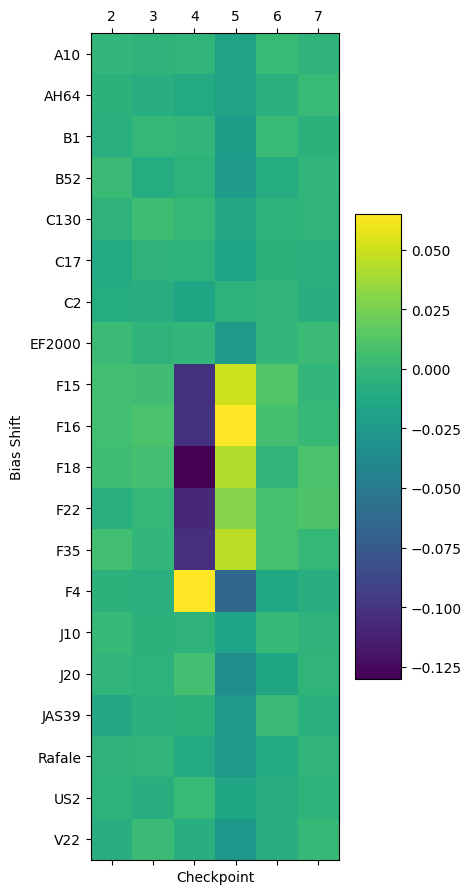

In [7]:
plot_heatmap(results, "squeeze_edit_model.classifier.4.bias")


### Authentrics software allows you to quickly identify critical issues

This can be incorporated into the training process, signaling issues with the training before preforming inference.

## Dynamic Analysis With Sensitivity

1. We run a stimulus of an f18 image through the model utilizing dymamic analysis on checkpoint 6 training data
2. We attenuate (lessen) the effects of that training content and evaluate impact

In [8]:
filepath = "sample_images/F18.jpg" # @param {"type":"string"}

### Vary the effect of the data in checkpoint 6 by 2%

In [ ]:
%%time
## Call Authentrics.ai software's sensitivity analysis
result = client.dynamic.single_sensitivity_analysis(
    project_id,
    project["file_list"][5]["id"],
    filepath,
    0.02,
)

CPU times: user 6.2 ms, sys: 2.01 ms, total: 8.2 ms
Wall time: 3.65 s


Below, we show that the image of the F18 is correctly identified with greater confidence when the influence of checkpoint 6's training is attenuated by 2%.

In [10]:
display_sensitivity_results(result, ["model_output", "attenuated_model_output"], classes)

,model_output,attenuated_model_output
A10,0.47957,0.36456
AH64,0.00386,0.00235
B1,0.00912,0.00603
B52,0.00237,0.00126
C130,0.05219,0.02953
C17,0.00940,0.00519
C2,0.00752,0.00452
EF2000,0.00370,0.00221
F15,0.07627,0.05128
F16,0.03883,0.02548


### Vary the effect of the data in checkpoint 6 by 4%

In [ ]:
%%time
## Call Authentrics.ai software's sensitivity analysis
result = client.dynamic.single_sensitivity_analysis(
    project_id,
    project["file_list"][5]["id"],
    filepath,
    0.04,
)

CPU times: user 2.54 ms, sys: 988 μs, total: 3.53 ms
Wall time: 3.2 s


Similarly, when amplified by 4%, the model increases its confidence. However, this amplified model must be checked against other stimuli to ensure that it does not skew the rest of the results (batch analysis to come).

In [12]:
display_sensitivity_results(result, ["model_output", "attenuated_model_output"], classes)

,model_output,attenuated_model_output
A10,0.12444,0.06718
AH64,0.00107,0.00040
B1,0.00328,0.00142
B52,0.00072,0.00020
C130,0.01854,0.00610
C17,0.00304,0.00094
C2,0.00277,0.00099
EF2000,0.00118,0.00042
F15,0.03314,0.01445
F16,0.01589,0.00672
